In [1]:
%load_ext autoreload
%autoreload 2

%matplotlib inline

import numpy as np
from sys import getsizeof
import matplotlib.pyplot as plt
from my_functions import FokkerPlankCalculator, get_pos
from scipy.linalg import expm
from tqdm.notebook import tqdm

# Time local equation --> Error

In [2]:
# Same as for escape dynamics
# #border = 0.002
# dt = 0.002
# k = 3
# max_t = 2
# #num_particle: 40000
# tau = 0
# D = 1e-6

# dx = 0.00002
# x_range = (-0.003,0.003)


# Same as in kroyProject
max_t = 2
avarage = 100
x_range = (-3e-3,3e-3)
dx = 0.00002
tau = 0.05#0.1
D = 1e-6
k = 10
dt = 1e-3 * 2

N_x = int(round((x_range[1] - x_range[0])/dx))+1
N_t = int(round(max_t/dt))+1
R = np.zeros((N_t, N_x, N_x))
data = np.zeros((N_t, N_x))
x_s = np.arange(x_range[0], x_range[1]+dx/2,dx)

In [3]:
data.shape

(1001, 301)

In [4]:
getsizeof(R)/1e6

725.532952

In [5]:
def get_D_w(D, max_t, dt, tau, k):
    my_fpc = FokkerPlankCalculator()
    s = np.sqrt(2*D)

    ts_all = np.arange(0, max_t+dt*5/4, dt/2)
    print(len(ts_all))
    ts = ts_all[::2]
    ts_ = ts_all[1::2]


    if tau > 0:
        max_p = int(max_t / tau) + 1
        print(max_p)
        l_data_all = my_fpc.l(k, tau, ts_all, max_p=max_p)
    else:
        l_data_all = np.exp(-k*ts_all)
    l_data = l_data_all[::2]
    l_data_ = l_data_all[1::2]

    w = my_fpc.get_w(l_data, l_data_, max_t)
    D_t_raw = my_fpc.get_D(l_data, l_data_, ts, max_t,D)
    return w, D_t_raw

In [6]:
w, D_t_raw = get_D_w(D, max_t, dt, tau, k)
D_t = D_t_raw #2*D_t_raw

2003
41


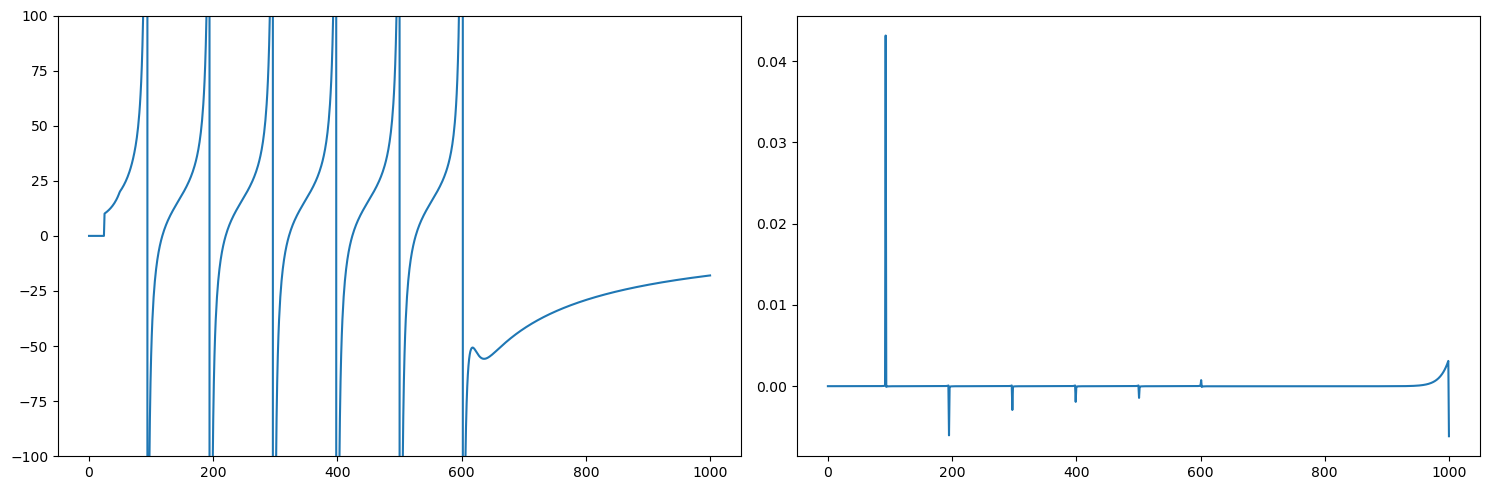

In [7]:
fig,axs = plt.subplots(1,2,figsize=(15,5))
axs[0].plot(w)
axs[0].set_ylim(-100,100)
axs[1].plot(D_t)
plt.tight_layout()

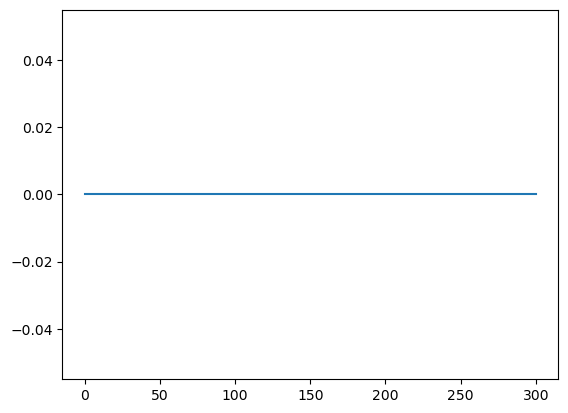

In [8]:
G = 0
U = (1/2*w[:,None]*x_s[None,:]**2 - G * x_s[None,:])/ D_t[:,None] 
plt.plot(U[0])

In [9]:
rip = D_t[:,None] / dx**2 * np.exp(-(U[:,1:]-U[:,:-1])/2) # r_i->i+1
rim = D_t[:,None] / dx**2 * np.exp(-(U[:,:-1]-U[:,1:])/2)  # r_i+1->i
R[:,0,0] = -rip[:,0]
R[:,-1,-1] = -rim[:,-1]
R[:,np.arange(1,300),np.arange(1,300)] = -(rip[:,1:]+rim[:,:-1]) # -(r_i->i+1 + r_i->i-1) ????
R[:,np.arange(0,300),np.arange(1,301)] = rim
R[:,np.arange(1,301),np.arange(0,300)] = rip
R.shape

(1001, 301, 301)

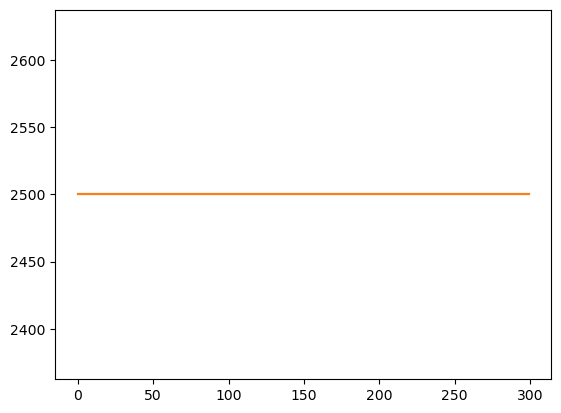

In [10]:
plt.plot(R[0,np.arange(1,301),np.arange(0,300)])
plt.plot(R[0,np.arange(0,300),np.arange(1,301)])

In [11]:
prop = np.stack([expm(o*dt) for o in R])

/home/nils/anaconda3/envs/kroy/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:375: RuntimeWarning: overflow encountered in matmul
  eAw = eAw @ eAw
/home/nils/anaconda3/envs/kroy/lib/python3.10/site-packages/scipy/linalg/_matfuncs.py:375: RuntimeWarning: invalid value encountered in matmul
  eAw = eAw @ eAw


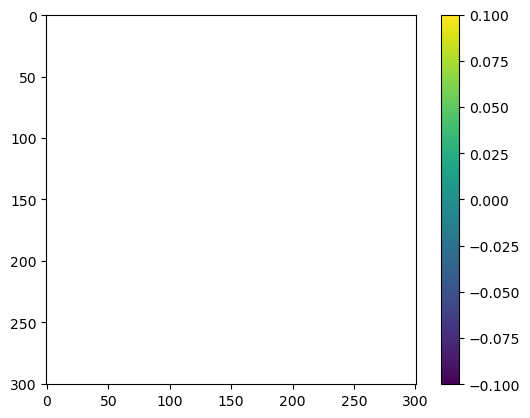

In [12]:
#plt.figure(figsize=(15,15))
plt.imshow(prop[-1])
plt.colorbar()

In [13]:
data[0,:] = 0
data[0,data.shape[1]//2] = 1

In [14]:
for i in range(1,len(data)):
    data[i] = prop[i-1]@data[i-1]

/tmp/ipykernel_30078/3961178829.py:2: RuntimeWarning: invalid value encountered in matmul
  data[i] = prop[i-1]@data[i-1]


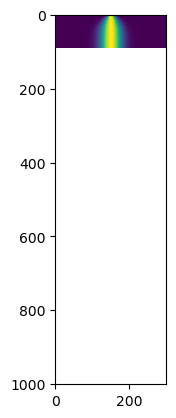

In [15]:
plt.imshow(data/data.max(axis=1)[:,None])

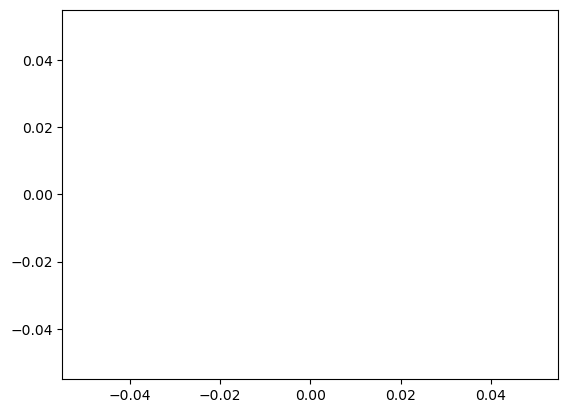

In [16]:
plt.plot(x_s,data[300])

# Itterative solution

In [2]:
max_t = 1 #2
#avarage = 100
x_range = (-3e-3,3e-3)
dx = 0.00002
tau = 0.15 #0.05#0.1
D = 1e-6
k = 10
dt = 1e-3 * 2

N_x = int(round((x_range[1] - x_range[0])/dx))+1
N_t = int(round(max_t/dt))+1
R = np.zeros((N_t, N_x, N_x))
data = np.zeros((N_t, N_x))
x_s = np.arange(x_range[0], x_range[1]+dx/2,dx)

ntau = int(tau/dt)
F = 0

D_t = np.zeros(N_t)
U = np.zeros((N_t,N_x))

In [3]:
if tau == 0:
    ntau = N_t
    D_t[:] = D #2*D
    U[:] = (1/2*k*x_s[None,:]**2 - F * x_s[None,:])/ D_t[:,None]
else:
    D_t[:ntau] = D #2*D
    U[:ntau] = 0

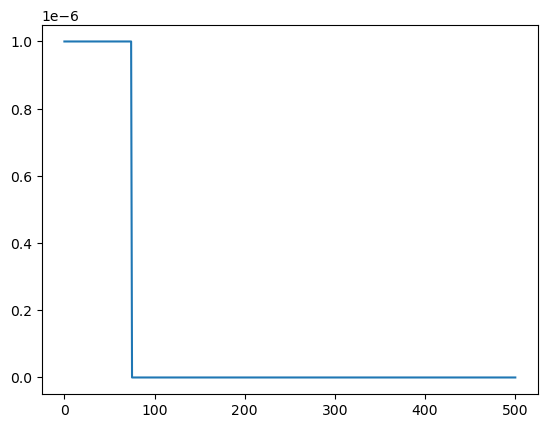

In [4]:
plt.plot(D_t)

In [5]:
rip = np.zeros((N_t,N_x-1))
rim = np.zeros((N_t,N_x-1))

ts = slice(0,ntau) #time slices
rip[ts] = D_t[ts,None] / dx**2 * np.exp(-(U[ts,1:]-U[ts,:-1])/2) # r_i->i+1
rim[ts] = D_t[ts,None] / dx**2 * np.exp(-(U[ts,:-1]-U[ts,1:])/2)  # r_i+1->i
R[ts,0,0] = -rip[ts,0]
R[ts,-1,-1] = -rim[ts,-1]
R[ts,np.arange(1,300),np.arange(1,300)] = -(rip[ts,1:]+rim[ts,:-1]) # -(r_i->i+1 + r_i->i-1) ????
R[ts,np.arange(0,300),np.arange(1,301)] = rim[ts]
R[ts,np.arange(1,301),np.arange(0,300)] = rip[ts]

In [6]:
prop = np.zeros((N_t,N_x,N_x))
prop[:ntau] = np.stack([expm(o*dt) for o in R[ts]])

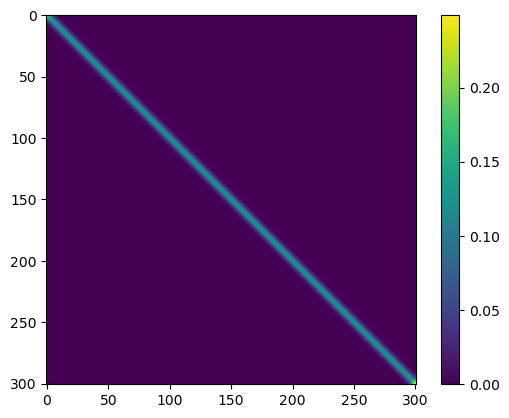

In [7]:
#plt.figure(figsize=(15,15))
plt.imshow(prop[1])
plt.colorbar()

In [8]:
data[0,:] = 0
data[0,data.shape[1]//2] = 1/dx

# Compare
pos = get_pos(
        num_particle=20_000,
        max_t = max_t,
        dt = dt,
        tau=tau,
        k=k,
        D=D,
        F=lambda t:0)
hists = np.stack([np.histogram(o, bins=x_s, density=True)[0] for o in pos])

75


In [9]:
for i in range(1,ntau+1):
    data[i] = prop[i-1]@data[i-1]
    
for i in tqdm(range(ntau, N_t-1)):
    dm = data[i-ntau]
    dtprop = np.identity(N_x)
    for j in range(i-ntau,i):
        dtprop = np.matmul(prop[j],dtprop)
    absrates = dtprop * dm
    origindists = absrates / absrates.sum(axis=1)[:,None]
    
    mx = origindists @ x_s
    mx2 = origindists @ x_s**2
    variants = mx2-mx**2
    
    meanFx = -k * mx
    
    #s = np.sqrt(2*D) -> D = s**2/2
    #D_t[i] = D + 1/2 * np.mean(variants)*k**2 #Wrong strongly correlated noise from prior position !!!!
    D_t[i] = D
    
    U[i] = -np.cumsum(meanFx)*dx / D_t[i]
    
    rip[i] = D_t[i,None] / dx**2 * np.exp(-(U[i,1:]-U[i,:-1])/2) # r_i->i+1
    rim[i] = D_t[i,None] / dx**2 * np.exp(-(U[i,:-1]-U[i,1:])/2)  # r_i+1->i
    R[i,0,0] = -rip[i,0]
    R[i,-1,-1] = -rim[i,-1]
    R[i,np.arange(1,300),np.arange(1,300)] = -(rip[i,1:]+rim[i,:-1]) # -(r_i->i+1 + r_i->i-1) ????
    R[i,np.arange(0,300),np.arange(1,301)] = rim[i]
    R[i,np.arange(1,301),np.arange(0,300)] = rip[i]
    
    prop[i] = expm(R[i]*dt)
    data[i+1] = prop[i]@data[i]

  0%|          | 0/425 [00:00<?, ?it/s]

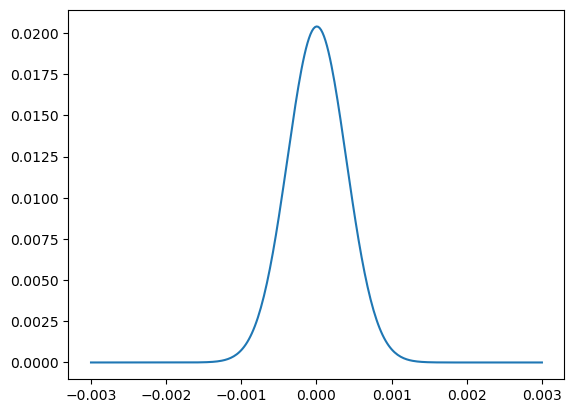

In [10]:
plt.plot(x_s,origindists[150])

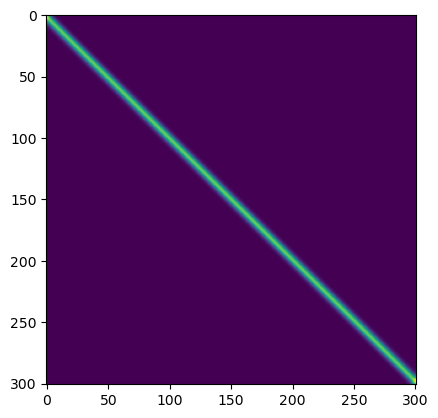

In [11]:
plt.imshow(prop[2*ntau])

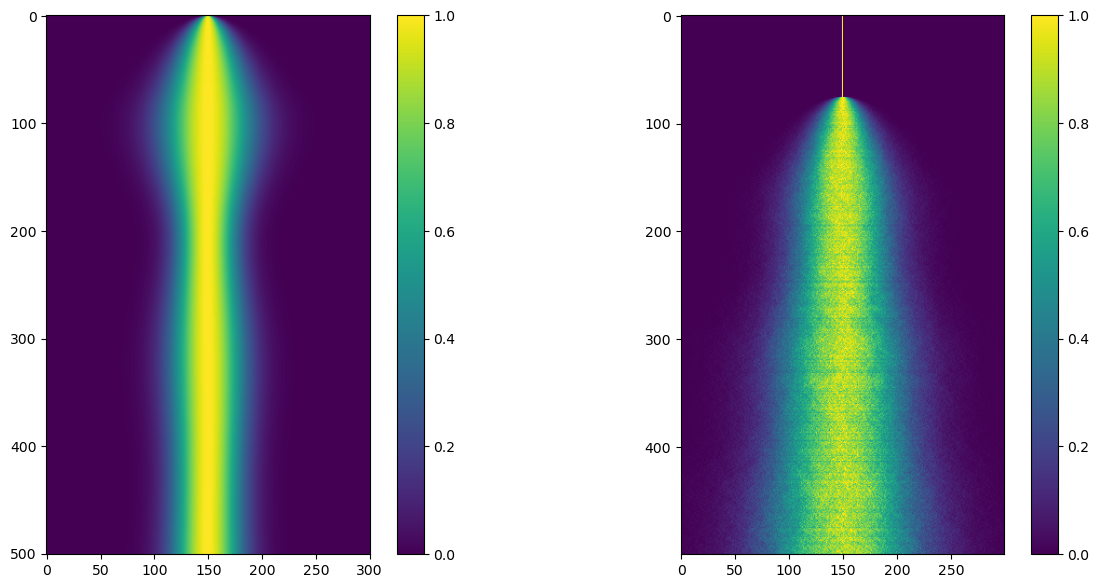

In [12]:
fig, axs = plt.subplots(1,2, figsize=(15,7))
ims1 = axs[0].imshow(data/data.max(axis=1)[:,None])
plt.colorbar(ims1, ax=axs[0])

ims2 = axs[1].imshow(hists/hists.max(axis=1)[:,None])
plt.colorbar(ims2, ax=axs[1])

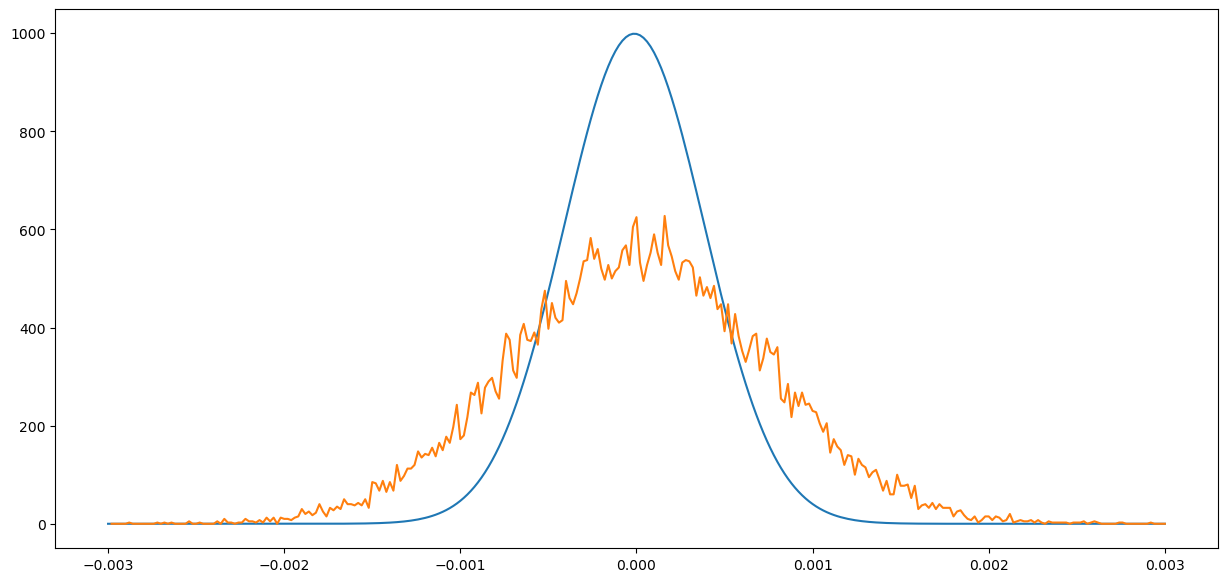

In [19]:
idx = 200
plt.figure(figsize=(15,7))
plt.plot(x_s,data[idx])
plt.plot(x_s[1:], hists[idx+ntau])
#plt.plot(x_s,dtprop[N_x//2]*1/dx)

In [ ]:
for idx in np.arange(0,1001,200):
    plt.plot(x_s,(U[idx]-np.min(U[idx]))*D_t[idx])
plt.plot(x_s, 1/2*k*x_s**2, ls = 'dashed')